In [553]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from numpy.linalg import inv
from numpy import linalg as LA
import math
from random import sample
from scipy.optimize import least_squares
import glob
import BitVector
import numpy as np
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})

# Image rectification

### Obtain an initial estimate of the fundamental matrix F
- 

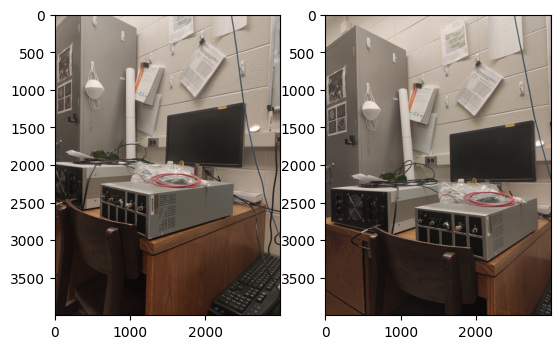

In [554]:
# 
img1 = cv.imread('img1.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
#img1_g = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

img2 = cv.imread('img2.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1)

ax2 = plt.subplot(122)
ax2.imshow(img2)

# plt.imshow(img1)


### extract 8 corresponding points

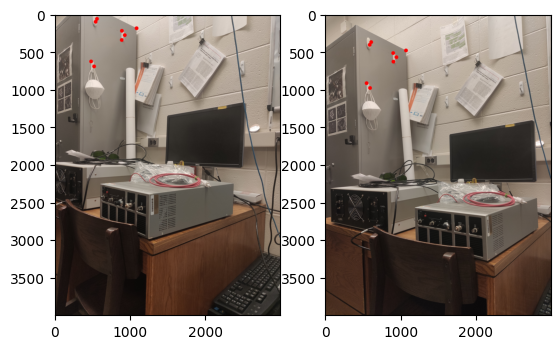

In [555]:
# manually extract corresponding points
cp_img1 = [[189, 1917], [64, 2443],  [103, 2461], [696, 2481],
           [630, 2521], [281, 2074], [345, 2114], [223, 2112]]

cp_img2 = [[484, 1925], [373, 2387], [409, 2407], [983, 2402],
           [919, 2448], [574, 2052], [633, 2092], [519, 2095]]

def reorg(cp_img):
    for i in range(len(cp_img)):
        x,y = 3000 - cp_img[i][1], cp_img[i][0]
        cp_img[i] = [x,y]
    return cp_img

cp_img1 = reorg(cp_img1)
cp_img2 = reorg(cp_img2)

        
img1_cp = img1.copy()
for [x,y] in cp_img1:
    cv.circle(img1_cp, (x,  y ), radius=25, color=(255, 0, 0), thickness=-1)  

img2_cp = img2.copy()    
for [x,y] in cp_img2:
    cv.circle(img2_cp, (x,  y ), radius=25, color=(255, 0, 0), thickness=-1)  
    
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1_cp)

ax2 = plt.subplot(122)
ax2.imshow(img2_cp)

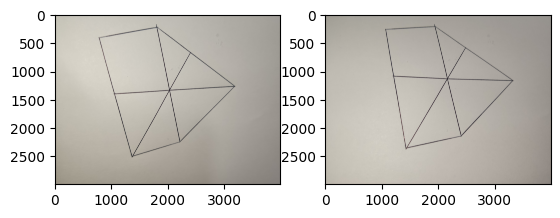

In [556]:
# 
img1 = cv.imread('img4.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
#img1_g = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

img2 = cv.imread('img5.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1)

ax2 = plt.subplot(122)
ax2.imshow(img2)

# plt.imshow(img1)

>>>>>>>>>>>>>>> Original image <<<<<<<<<<<<<<<


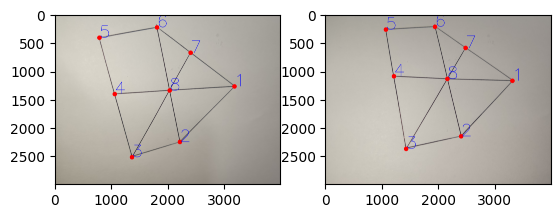

In [557]:
# manually extract corresponding points

cp_img1 = [[824, 1723], [1790, 743],  [2638,474], [2943,1588],
           [3214,2582], [2194,2764], [1600,2317], [1971,1651]]

cp_img2 = [[683,1822], [1591,843], [2564,621], [2780,1902],
           [2923,2726], [2053,2775], [1512,2402], [1834,1856]]

def reorg(cp_img):
    for i in range(len(cp_img)):
        x,y = 3000 - cp_img[i][1], 4000 -cp_img[i][0]
        cp_img[i] = [y,x]
    return cp_img

cp_img1 = reorg(cp_img1)
cp_img2 = reorg(cp_img2)

        
img1_cp = img1.copy()
pos = 0
for [x,y] in cp_img1:
    pos += 1
    cv.circle(img1_cp, (x, y), radius=40, color=(255, 0, 0), thickness=-1)  
    img1_cp = cv.putText(img1_cp, str(pos), (int(x-5), int(y-5)), cv.FONT_HERSHEY_SIMPLEX, 10, (0,0, 255), 5, cv.LINE_AA)
        
img2_cp = img2.copy() 
pos = 0
for [x,y] in cp_img2:
    pos += 1
    cv.circle(img2_cp, (x, y), radius=40, color=(255, 0, 0), thickness=-1)  
    img2_cp = cv.putText(img2_cp, str(pos), (int(x-5), int(y-5)), cv.FONT_HERSHEY_SIMPLEX, 10, (0,0, 255), 5, cv.LINE_AA)
      
print('>>>>>>>>>>>>>>> Original image <<<<<<<<<<<<<<<')
        
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1_cp)

ax2 = plt.subplot(122)
ax2.imshow(img2_cp)

### draw lines connecting the corresponding points

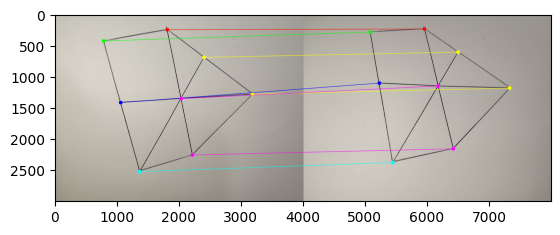

In [558]:
# assuem two images have the same size
def drawline(img1, img2, cp_img1, cp_img2, skip):
    colors = ((255,255,0), (255,0,255),(0,255,255),(0,0,255),(0,255,0),(255,0,0))
    
    img_new = np.concatenate((img1,img2),1)
    
    for i in range(len(cp_img1)):
        if i%skip == 0:
            if len(cp_img1[i]) == 3:
                x1,y1,_ = cp_img1[i]
                x2,y2,_ = cp_img2[i]
            elif len(cp_img1[i]) == 2:
                x1,y1 = cp_img1[i]
                x2,y2 = cp_img2[i]
            x2 += img1.shape[1]
            x1,y1 = int(x1),int(y1)
            x2,y2 = int(x2),int(y2)
            
            cv.line(img_new, (x1,y1), (x2,y2), colors[i%len(colors)],5)
            cv.circle(img_new, (x1,y1),30, colors[i%len(colors)], -1)
            cv.circle(img_new, (x2,y2),30, colors[i%len(colors)], -1)
            
    
    plt.imshow(img_new)
    
drawline(img1, img2, cp_img1, cp_img2, 1)

### normalize

In [559]:
cp_img2 = np.array(cp_img2)

x_ave, y_ave = np.mean(cp_img2[:,0]), np.mean(cp_img2[:,1])

D_list = [0]*len(cp_img2)

for i in range(len(cp_img2)):
    D_list[i] = ((cp_img2[i,0] - x_ave)**2 + (cp_img2[i,1] - y_ave)**2)**0.5
    
D = np.mean(D_list)

C = 2**0.5/D

T2_norm = np.array([[C,0,-C*x_ave],
                    [0,C,-C*y_ave],
                    [0,0, 1]]) 

cp_img2 = np.append(cp_img2, np.array([[1]*len(cp_img2)]).T, axis=1)
cp_img2_norm = (T2_norm @ cp_img2.T).T

In [560]:
cp_img1 = np.array(cp_img1)

x_ave, y_ave = np.mean(cp_img1[:,0]), np.mean(cp_img1[:,1])

D_list = [0]*len(cp_img1)

for i in range(len(cp_img1)):
    D_list[i] = ((cp_img1[i,0] - x_ave)**2 + (cp_img1[i,1] - y_ave)**2)**0.5
    
D = np.mean(D_list)

C = 2**0.5/D

T1_norm = np.array([[C,0,-C*x_ave],
                    [0,C,-C*y_ave],
                    [0,0, 1]]) 

cp_img1 = np.append(cp_img1, np.array([[1]*len(cp_img1)]).T, axis=1)
cp_img1_norm = (T1_norm @ cp_img1.T).T

### Calculate fundamental matrix F

In [561]:
# assume F33 = 1
def F_cal(cp_img1, cp_img2):
    A_mat = []
    # F = [F11, F12, F13, F21, F22, F23, F31, F32]
    for i in range(len(cp_img1)):
        x1, y1, _ = cp_img1[i]
        x2, y2, _ = cp_img2[i]
        
        A_point = [x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1]
        A_mat.append(A_point)
    b_vect = np.array([-1]*len(cp_img1))
        
    A_mat = np.array(A_mat)
    
    #b_vect = np.array([-1]*len(cp_img1))
    #print(inv(A_mat))
    #_, eigen_val, eigen_vect = np.linalg.svd(A_mat)
    #F_vect = eigen_vect[-1]
    
    F_vect = np.matmul(inv(A_mat),b_vect)
    #print('eigen_val', eigen_val)
    
    #F_vect = F_vect/F_vect[-1]
    
    F_mat = [[F_vect[0], F_vect[1], F_vect[2]],
             [F_vect[3], F_vect[4], F_vect[5]],
             [F_vect[6], F_vect[7], 1]]
    
    F_mat = np.array(F_mat)
    
    print(A_mat @ F_vect - b_vect)
    
    print('F_mat = \n', F_mat)
    
    return F_mat

F = F_cal(cp_img1_norm, cp_img2_norm)

[ 4.26547686e-13  2.95985458e-13 -3.69926312e-13 -4.41424675e-13
 -4.11892742e-13 -3.59712260e-14  1.41220369e-13  7.99360578e-14]
F_mat = 
 [[-0.0097426  -0.30414197  4.84535932]
 [-0.29399224 -0.77627803  7.60633912]
 [-5.71079246 -7.38173317  1.        ]]


### condition rank(F) = 2

In [562]:
a,b,c = np.linalg.svd(F, full_matrices=False)
a,b,c

b = np.array([[b[0], 0, 0],
              [0, b[1], 0],
              [0, 0 , 0]])

F = a @ b @ c  

#F

In [563]:
F = T2_norm.T @ F @ T1_norm
#F

In [564]:
# test
def F_test(cp_img1, cp_img2, F):    
    loss = 0
    
    for i in range(len(cp_img1)):
        cp1_homo = np.array(cp_img1[i] + [1])
        cp2_homo = np.array(cp_img2[i] + [1])
    
        loss += cp2_homo @ F @ cp1_homo.T
        # print(cp2_homo @ F @ cp1_homo.T)
    
    return loss

F_test(cp_img1, cp_img2, F)

0.9706443623732532

### Estimate left and right epipoles

In [565]:
_, eigen_val, null_r = np.linalg.svd(F)
e1 = null_r[-1]
#e1 = e1/e1[-1]
e1

array([-7.19316521e-01,  6.94682474e-01,  4.93596426e-05])

In [566]:
np.matmul(F,e1)

array([-5.93134821e-19, -1.07986113e-18,  4.60514873e-17])

In [567]:
_, eigen_val, null_l = np.linalg.svd(F.T)
e2 = null_l[-1]
#e2 = e2/e2[-1]
e2

array([ 8.77049660e-01, -4.80399722e-01,  3.37563384e-05])

In [568]:
np.matmul(e2.T,F)

array([-2.60092054e-19, -2.83967796e-19,  2.07556953e-16])

### Calculate P and P_prime (P1 and P2)

In [569]:
P1 = np.array([[1,0,0,0], 
               [0,1,0,0],
               [0,0,1,0]])
# 
s = [[0,-e2[2],e2[1]],
     [e2[2],0,-e2[0]],
     [-e2[1],e2[0],0]]

sF = np.matmul(s,F)

P2 = np.append(sF, np.array([e2]).T, axis=1)

### refine the right projective matrix with nonlinear optomization

In [570]:
#P2

In [571]:
def X_cal(P1,P2,X1,X2):
    x1,y1,_ = X1
    x2,y2,_ = X2
    
    A = np.array([x1*P1[2] - P1[0],
                  y1*P1[2] - P1[1],
                  x2*P2[2] - P2[0],
                  y2*P2[2] - P2[1]])
    
    _, eigen_val, eigen_vect = np.linalg.svd(A)
    
    X = eigen_vect[-1]
    X = X/X[-1]
    
    return X

X_cal(P1,P2,cp_img1[1],cp_img2[1])

array([1.73114634e+02, 1.76796257e+02, 7.83324146e-02, 1.00000000e+00])

In [572]:
def project(P,X):
    x = np.matmul(P,X)
    x = x/[x[-1]]
    
    return x

In [573]:
project(P1,X_cal(P1,P2,cp_img1[1],cp_img2[1]))

array([2.20999997e+03, 2.25699996e+03, 1.00000000e+00])

In [574]:
def cost(P2_vect, P1 = P1, cp_img1 = cp_img1, cp_img2 = cp_img2):
    P2 = P2_vect.reshape([3,4]) 
    
    res = [0]*len(cp_img1)
    
    for i in range(len(res)):
        X = X_cal(P1,P2, cp_img1[i], cp_img2[i])
        x_proj = project(P2,X)
        
        res[i] = (x_proj[0] - cp_img2[i][0])**2 + (x_proj[1] - cp_img2[i][1])**2
    
    return res

#cost(P2.flatten())

In [575]:
Res = least_squares(cost, P2.flatten() , method = 'dogbox', args = [P1, cp_img1, cp_img2])
P2_refine = Res.x.reshape([3,4])
#P2_refine

In [576]:
#print(P2, '\n', P2_refine, '\n',  P2_refine - P2)

In [577]:
#cost(P2_refine.flatten())

### refine fundamental matrix F.
As two images are taken by the same camera: F = P2*[0,0,0,1]

In [578]:
F_refine_vect = np.matmul(P2_refine, np.array([0,0,0,1]))

F_refine = np.array([[0,-F_refine_vect[2],F_refine_vect[1]],
                     [F_refine_vect[2], 0, -F_refine_vect[0]],
                     [-F_refine_vect[1], F_refine_vect[0], 0]])

F_refine

array([[ 0.00000000e+00, -2.99849797e-05, -4.80602455e-01],
       [ 2.99849797e-05,  0.00000000e+00, -8.76925828e-01],
       [ 4.80602455e-01,  8.76925828e-01,  0.00000000e+00]])

### Refine epipoles

In [579]:
_, eigen_val, null_l = np.linalg.svd(F_refine.T)
e2 = null_l[-1]
e2 = e2/e2[-1]
e2

_, eigen_val, null_r = np.linalg.svd(F_refine)
e1 = null_r[-1]
e1 = e1/e1[-1]
e1

array([ 2.92455034e+04, -1.60281067e+04,  1.00000000e+00])

### Estimate right homography matrix

### H = T_2 *G R T_1

In [580]:
# move image center to origin T1, T2
T1 = np.array([[1, 0, -img2.shape[0]/2],
               [0, 1, -img2.shape[1]/2],
               [0, 0, 1]])


# theta
theta = np.arctan((e2[1] - img2.shape[1]/2)/(-e2[0] - img2.shape[0]/2))

print('theta = ', theta)

R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0            , 0             , 1]])

R_T = np.matmul(R,T1)

#print(np.matmul(R_T,e2))

f = np.matmul(R_T,e2)[0]

print('f = ', f)

# G
G = np.array([[1,0,0],
              [0,1,0],
              [-1/f, 0,1]])

# T2
H_now = G @ R @ T1

center =np.matmul( H_now, np.array([img2.shape[0]/2, img2.shape[1]/2, 1]))
center = center/center[-1]

# print(H_now, np.array([img2.shape[0]/2, img2.shape[1]/2, 1]), center)

T2 = np.array([[1, 0, img2.shape[0]/2 - center[0]],
               [0, 1, img2.shape[1]/2 - center[1]],
               [0, 0, 1]])

H2 = T2 @ G @ R @ T1

H2

theta =  0.5303339071087436
f =  33053.3341077991


array([[ 8.23490663e-01, -4.82866627e-01,  1.23049726e+03],
       [ 4.53624666e-01,  8.93244599e-01, -4.66926196e+02],
       [-2.60983724e-05,  1.53031887e-05,  1.00854118e+00]])

In [581]:
img2_proj = cv.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))
#plt.imshow(img2_proj)

### Estimate left homography matrix

In [582]:
e1 = e1/e1[-1]
e1

# move image center to origin T1, T2
T1 = np.array([[1, 0, -img1.shape[0]/2],
               [0, 1, -img1.shape[1]/2],
               [0, 0, 1]])



# theta
theta = np.arctan((e1[1] - img1.shape[1]/2)/(-e1[0] - img1.shape[0]/2))

R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0            , 0             , 1]])

R_T = np.matmul(R,T1)

print(np.matmul(R_T,e1))

f = np.matmul(R_T,e1)[0]

# G
G = np.array([[1,0,0],
              [0,1,0],
              [-1/f, 0,1]])


H_tilda = G @ R @ T1

H_tilda

[ 3.30533341e+04 -1.51746423e+03  1.00000000e+00]


array([[ 8.62638221e-01, -5.05821410e-01, -2.82314511e+02],
       [ 5.05821410e-01,  8.62638221e-01, -2.48400856e+03],
       [-2.60983724e-05,  1.53031887e-05,  1.00854118e+00]])

In [583]:
def linear_abc(H_tilda, cp_img1, H2, cp_img2):
    A = []
    b_vect = []
    
    for x,y,k in cp_img1:
        vect = H_tilda @ np.array([x,y,1])
        vect = vect/vect[-1]
        
        x,y = vect[0],vect[1]
        
        A.append([x,y,1])
    
    for [x,y,k] in cp_img2:
        
        vect = H2 @ np.array([x,y,1])
        vect = vect/vect[-1]
        x,y = vect[0],vect[1]
        
        b_vect.append(x)
        
        # b_vect.append(x**2)
    
    A = np.array(A)
    b_vect = np.array(b_vect)
    
    a,b,c = (inv(A.T @ A) @ A.T) @ b_vect
  
#     print(A,'\n',b_vect)
    # print((A @ np.array([a,b,c]) - b_vect)/ b_vect)
    
    return np.array([[a,b,c], [0,1,0], [0,0,1]])

linear_abc(H_tilda, cp_img1,H2, cp_img2)

array([[ 9.60377742e-01, -2.81304522e-02,  1.72654465e+03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [584]:
# T2
H_now = linear_abc(H_tilda, cp_img1,H2, cp_img2) @ H_tilda


center = H_now @ np.array([img1.shape[0]/2, img1.shape[1]/2, 1])
center = center/center[-1]

T2 = np.array([[1, 0, img1.shape[0]/2 - center[0]],
               [0, 1, img1.shape[1]/2 - center[1]],
               [0, 0, 1]])

In [585]:
H1 = T2 @ linear_abc(H_tilda, cp_img1,H2, cp_img2) @ H_tilda
H1

array([[ 7.75082004e-01, -4.87091244e-01,  1.31155948e+03],
       [ 4.53624666e-01,  8.93244599e-01, -4.66926196e+02],
       [-2.60983724e-05,  1.53031887e-05,  1.00854118e+00]])

In [586]:
img1_proj = cv.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
#plt.imshow(img1_proj)

### Rectify the images

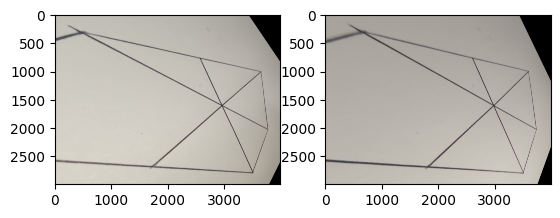

In [376]:
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1_proj)

ax2 = plt.subplot(122)
ax2.imshow(img2_proj)

In [415]:
def project_p(H, points):
    points_new = []
    for i in range(len(points)):
        vect = points[i]
        vect_new = H @ vect
        vect_new = vect_new/vect_new[-1]
        
        points_new.append(vect_new)
    return np.array(points_new)

In [416]:
cp_img1_p = project_p(H1, cp_img1)
cp_img2_p = project_p(H2, cp_img2)

## Draw lines connecting corresponding points for rectified images

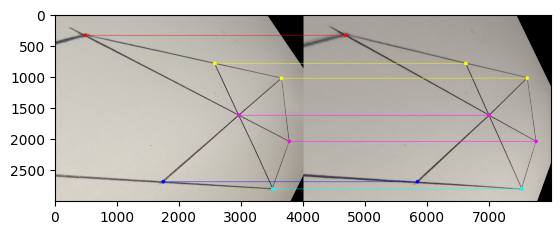

In [417]:
drawline(img1_proj, img2_proj, cp_img1_p, cp_img2_p, 1)

In [323]:
H1-H2

array([[-4.63658172e+00, -2.73039558e+00,  7.95075583e+03],
       [-1.65234195e-01, -1.65823270e+00,  3.86493748e+02],
       [-7.90294628e-04, -1.95517274e-04,  0.00000000e+00]])

# 2.2 Interest Point Detection

### Canny edge detector

In [388]:
img1_gray = cv.cvtColor(img1_proj, cv.COLOR_BGR2GRAY)
img1_gray = cv.blur(img1_gray , (3,3))
edges_1 = cv.Canny(img1_gray,100,100,5) # return 0 or 255

In [387]:
img2_gray = cv.cvtColor(img2_proj, cv.COLOR_BGR2GRAY)
img2_gray = cv.blur(img2_gray , (3,3))
edges_2 = cv.Canny(img2_gray,100,100,5) # return 0 or 255

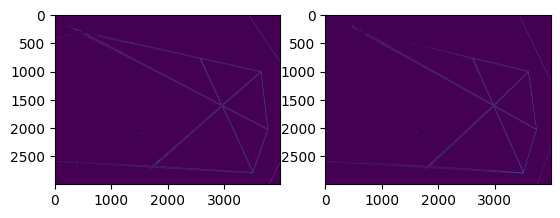

In [389]:
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(edges_1)

ax2 = plt.subplot(122)
ax2.imshow(edges_2)

## NCC - build the corresponding points

In [510]:
# find correspondance points
edges_1
edges_2
M = 101
d_max = 200

points1 = []
points2 = []

for row in range(len(edges_1)):
    col_list = np.where(edges_1[row]>0)[0]
    
    if len(col_list)>0:
        for col in col_list:
            vect = edges_2[row, col:col + d_max +1]
            candi = np.where(vect>0)[0]
            if len(candi)>0:
                col_2 = col + candi[0]
                points1.append([col,row])
                points2.append([col_2, row])
    # print(len(col_list))


In [511]:
M_half = M//2

cost = [10**10]*len(points1)

for i in range(len(points1)):
    x1,y1 = points1[i]
    x2,y2 = points2[i]
    
    if x1-M_half>0 and x1+M_half+1<len(points1) and  y1-M_half>0 and y1+M_half+1<len(points1[0]) and x2-M_half>0 and x2+M_half+1<len(points2) and  y2-M_half>0 and y2+M_half+1<len(points2[0]):
        
        wind1 = img1_gray[x1-M_half:x1+M_half+1, y1-M_half:y1+M_half+1]
        wind2 = img2_gray[x2-M_half:x2+M_half+1, y2-M_half:y2+M_half+1]
        cost_cur = ((wind1 - wind2)**2).sum() 
        cost[i] = cost_cur
#     if cost_cur != 0:
#         cost[i] = cost_cur 
        
points1_sorted = [pt1 for _,pt1,pt2 in sorted(zip(cost, points1, points2), key = lambda x: x[0])]
points2_sorted = [pt2 for _,pt1,pt2 in sorted(zip(cost, points1, points2), key = lambda x: x[0])]


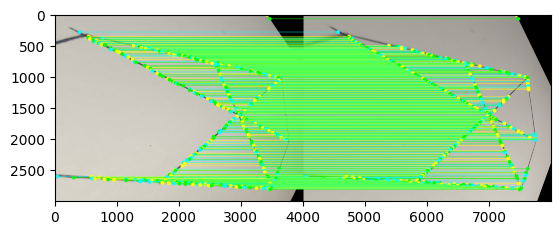

In [513]:
drawline(img1_proj, img2_proj, points1_sorted[0:50000], points2_sorted[0:50000], 100)

# 2.3 Projective reconstruction

In [546]:
cp_img1 = points1_sorted[0:50000]
cp_img2 = points2_sorted[0:50000]

In [547]:
cp_img2 = np.array(cp_img2)

x_ave, y_ave = np.mean(cp_img2[:,0]), np.mean(cp_img2[:,1])

D_list = [0]*len(cp_img2)

for i in range(len(cp_img2)):
    D_list[i] = ((cp_img2[i,0] - x_ave)**2 + (cp_img2[i,1] - y_ave)**2)**0.5
    
D = np.mean(D_list)

C = 2**0.5/D

T2_norm = np.array([[C,0,-C*x_ave],
                    [0,C,-C*y_ave],
                    [0,0, 1]]) 

cp_img2 = np.append(cp_img2, np.array([[1]*len(cp_img2)]).T, axis=1)
cp_img2_norm = (T2_norm @ cp_img2.T).T

In [548]:
cp_img1 = np.array(cp_img1)

x_ave, y_ave = np.mean(cp_img1[:,0]), np.mean(cp_img1[:,1])

D_list = [0]*len(cp_img1)

for i in range(len(cp_img1)):
    D_list[i] = ((cp_img1[i,0] - x_ave)**2 + (cp_img1[i,1] - y_ave)**2)**0.5
    
D = np.mean(D_list)

C = 2**0.5/D

T1_norm = np.array([[C,0,-C*x_ave],
                    [0,C,-C*y_ave],
                    [0,0, 1]]) 

cp_img1 = np.append(cp_img1, np.array([[1]*len(cp_img1)]).T, axis=1)
cp_img1_norm = (T1_norm @ cp_img1.T).T

In [549]:
def F_cal(cp_img1, cp_img2):
    A_mat = []
    # F = [F11, F12, F13, F21, F22, F23, F31, F32]
    for i in range(len(cp_img1)):
        x1, y1, _ = cp_img1[i]
        x2, y2, _ = cp_img2[i]
        
        A_point = [x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1]
        A_mat.append(A_point)
    b_vect = np.array([-1]*len(cp_img1))
        
    A_mat = np.array(A_mat)
    
    #b_vect = np.array([-1]*len(cp_img1))
    #print(inv(A_mat))
    #_, eigen_val, eigen_vect = np.linalg.svd(A_mat)
    #F_vect = eigen_vect[-1]
    
    F_vect = np.matmul(np.linalg.pinv(A_mat),b_vect)
    #print('eigen_val', eigen_val)
    
    #F_vect = F_vect/F_vect[-1]
    
    F_mat = [[F_vect[0], F_vect[1], F_vect[2]],
             [F_vect[3], F_vect[4], F_vect[5]],
             [F_vect[6], F_vect[7], 1]]
    
    F_mat = np.array(F_mat)
    
    print(A_mat @ F_vect - b_vect)
    
    print('F_mat = \n', F_mat)
    
    return F_mat

F = F_cal(cp_img1_norm, cp_img2_norm)

[-2.91608501 -2.91506818 -2.91376194 ... -0.60497605 -0.61150408
 -0.60685818]
F_mat = 
 [[-0.11346321  1.02816812  0.52776835]
 [-0.89953763 -0.53704953  0.07768557]
 [-0.86094016  0.07625823  1.        ]]


In [550]:
a,b,c = np.linalg.svd(F, full_matrices=False)
a,b,c

b = np.array([[b[0], 0, 0],
              [0, b[1], 0],
              [0, 0 , 0]])

F = a @ b @ c  

F = T2_norm.T @ F @ T1_norm

_, eigen_val, null_r = np.linalg.svd(F)
e1 = null_r[-1]
#e1 = e1/e1[-1]
e1

_, eigen_val, null_l = np.linalg.svd(F.T)
e2 = null_l[-1]
#e2 = e2/e2[-1]
e2

P1 = np.array([[1,0,0,0], 
               [0,1,0,0],
               [0,0,1,0]])
# 
s = [[0,-e2[2],e2[1]],
     [e2[2],0,-e2[0]],
     [-e2[1],e2[0],0]]

sF = np.matmul(s,F)

P2 = np.append(sF, np.array([e2]).T, axis=1)

# Res = least_squares(cost, P2.flatten() , method = 'dogbox', args = [P1, cp_img1, cp_img2])
# P2_refine = Res.x.reshape([3,4])
P2_refine = P2
 
    
F_refine_vect = np.matmul(P2_refine, np.array([0,0,0,1]))

F_refine = np.array([[0,-F_refine_vect[2],F_refine_vect[1]],
                     [F_refine_vect[2], 0, -F_refine_vect[0]],
                     [-F_refine_vect[1], F_refine_vect[0], 0]])

F_refine

_, eigen_val, null_l = np.linalg.svd(F_refine.T)
e2 = null_l[-1]
e2 = e2/e2[-1]
e2

_, eigen_val, null_r = np.linalg.svd(F_refine)
e1 = null_r[-1]
e1 = e1/e1[-1]
e1

T1 = np.array([[1, 0, -img2.shape[0]/2],
               [0, 1, -img2.shape[1]/2],
               [0, 0, 1]])


# theta
theta = np.arctan((e2[1] - img2.shape[1]/2)/(-e2[0] - img2.shape[0]/2))

print('theta = ', theta)

R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0            , 0             , 1]])

R_T = np.matmul(R,T1)

#print(np.matmul(R_T,e2))

f = np.matmul(R_T,e2)[0]

print('f = ', f)

# G
G = np.array([[1,0,0],
              [0,1,0],
              [-1/f, 0,1]])

# T2
H_now = G @ R @ T1

center =np.matmul( H_now, np.array([img2.shape[0]/2, img2.shape[1]/2, 1]))
center = center/center[-1]

# print(H_now, np.array([img2.shape[0]/2, img2.shape[1]/2, 1]), center)

T2 = np.array([[1, 0, img2.shape[0]/2 - center[0]],
               [0, 1, img2.shape[1]/2 - center[1]],
               [0, 0, 1]])

H2 = T2 @ G @ R @ T1

H2

e1 = e1/e1[-1]
e1

# move image center to origin T1, T2
T1 = np.array([[1, 0, -img1.shape[0]/2],
               [0, 1, -img1.shape[1]/2],
               [0, 0, 1]])



# theta
theta = np.arctan((e1[1] - img1.shape[1]/2)/(-e1[0] - img1.shape[0]/2))

R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0            , 0             , 1]])

R_T = np.matmul(R,T1)

print(np.matmul(R_T,e1))

f = np.matmul(R_T,e1)[0]

# G
G = np.array([[1,0,0],
              [0,1,0],
              [-1/f, 0,1]])


H_tilda = G @ R @ T1

H_tilda

H_now = linear_abc(H_tilda, cp_img1,H2, cp_img2) @ H_tilda


center = H_now @ np.array([img1.shape[0]/2, img1.shape[1]/2, 1])
center = center/center[-1]

T2 = np.array([[1, 0, img1.shape[0]/2 - center[0]],
               [0, 1, img1.shape[1]/2 - center[1]],
               [0, 0, 1]])

H1 = T2 @ linear_abc(H_tilda, cp_img1,H2, cp_img2) @ H_tilda

theta =  0.3696102461829811
f =  649.2437446376
[ 6.49243745e+02 -1.08375608e+03  1.00000000e+00]


In [551]:
img2_proj = cv.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))
img1_proj = cv.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))

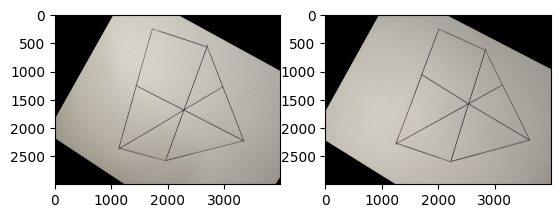

In [587]:
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(img1_proj)

ax2 = plt.subplot(122)
ax2.imshow(img2_proj)

- somehow the result becomes worse, don't have time to debug

# TASK 2: The loop and Zhang algorithm

### Apply LoopAndZhang algorithm, the program doesn't work on one set of my image. So I only show the result of one image set.

### It looks that the LoopAndZhang algorithm works better than my program. It rectifies the image with minimum distortion. But the stability is not very good (one of my image set doesn't work.). The algorithm is more suitable for images with complex features.

### Key points for Loop and Zhang algorithm

- Loop and Zhang algorithm decompose the rectification to three Homographies: projective homography, similarity homography and shearing homography.

- projective homography sends the epipoles to infinity with smalllest distortion to the original image.

- use similarity homography to rotate, translate, and uniformly scale the image

- shearing transforms further reduces the distortion on the image

>>>>>>> Original Image >>>>>>>>


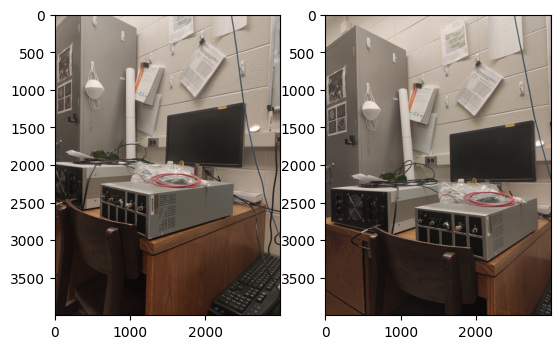

In [3]:
# original image
LZ1 = cv.imread('img1.jpg')
LZ1 = cv.cvtColor(LZ1, cv.COLOR_BGR2RGB)

LZ2 = cv.imread('img2.jpg')
LZ2 = cv.cvtColor(LZ2, cv.COLOR_BGR2RGB)

print('>>>>>>> Original Image >>>>>>>>')
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(LZ1)

ax2 = plt.subplot(122)
ax2.imshow(LZ2)

>>>>>>> Before rectification >>>>>>>>


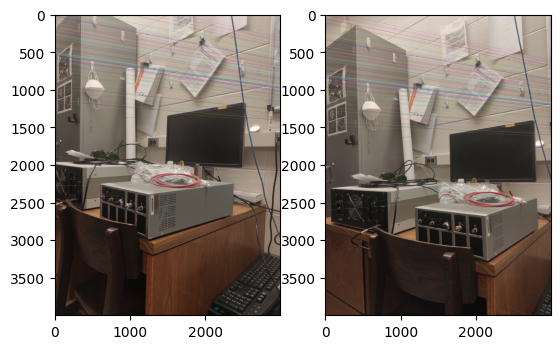

In [5]:
# After rectification
LZ1 = cv.imread('1.jpg')
LZ1 = cv.cvtColor(LZ1, cv.COLOR_BGR2RGB)

LZ2 = cv.imread('2.jpg')
LZ2 = cv.cvtColor(LZ2, cv.COLOR_BGR2RGB)

print('>>>>>>> Before rectification >>>>>>>>')
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(LZ1)

ax2 = plt.subplot(122)
ax2.imshow(LZ2)

>>>>>>> After rectification >>>>>>>>


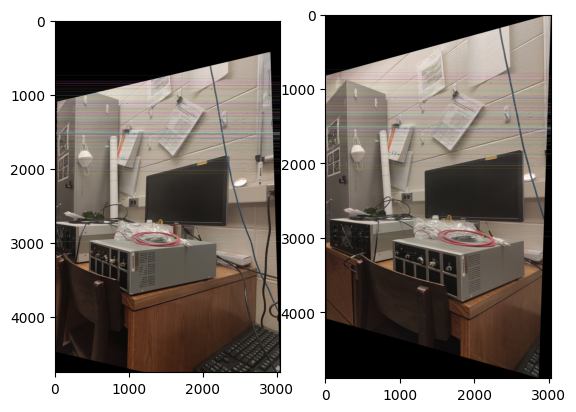

In [221]:
# After rectification
LZ1 = cv.imread('1_rectificada.jpg')
LZ1 = cv.cvtColor(LZ1, cv.COLOR_BGR2RGB)

LZ2 = cv.imread('2_rectificada.jpg')
LZ2 = cv.cvtColor(LZ2, cv.COLOR_BGR2RGB)

print('>>>>>>> After rectification >>>>>>>>')
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(LZ1)

ax2 = plt.subplot(122)
ax2.imshow(LZ2)

# TASK 3: Dense Stereo Matching

### Description

- The aim is to find corresponding pixels in two stereo rectified images. The dispartity map shows the distance in x direction between two corresponding pixels.

- Census transform builds correspondance pixels using the information of neigboring pixels. 

- The accurracy of Census transform increases as I increase the MxM window size. The accuracy increase from 0.70 to 0.76 as the M is increase from 11 to 21.

>>>>>>> rectified stereo images pair >>>>>>>>


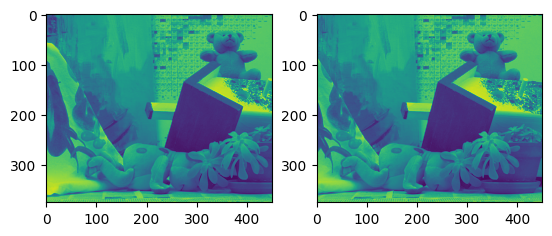

In [62]:
im2 = cv.imread('im2.png')
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

im6 = cv.imread('im6.png')
im6 = cv.cvtColor(im6, cv.COLOR_BGR2RGB)
im6 = cv.cvtColor(im6, cv.COLOR_BGR2GRAY)

print('>>>>>>> rectified stereo images pair >>>>>>>>')
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(im2)

ax2 = plt.subplot(122)
ax2.imshow(im6)

>>>>>>> ground trueth GT disparity images pair >>>>>>>>


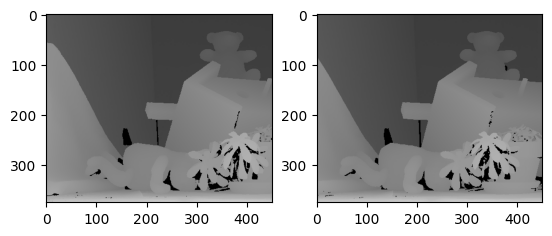

In [17]:
disp2 = cv.imread('disp2.png')

disp6 = cv.imread('disp6.png')

print('>>>>>>> ground trueth GT disparity images pair >>>>>>>>')
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(disp2)

ax2 = plt.subplot(122)
ax2.imshow(disp6)

In [33]:
disp6 = cv.imread('disp6.png')

disp6 = disp6.astype(np.float32)/4;
disp6 = disp6.astype(np.uint8);

d_max = disp6.max()
print('disp6: d_max >>', d_max)

#plt.imshow(disp6)

disp6: d_max >> 52


In [31]:
disp2 = cv.imread('disp2.png')

disp2 = disp2.astype(np.float32)/4;
disp2 = disp2.astype(np.uint8);

d_max = disp2.max()
print('disp2: d_max >>', d_max)

#plt.imshow(disp2)

d_max >> 52


>>>>>>>>>>> M = 11 <<<<<<<<<<<<<<


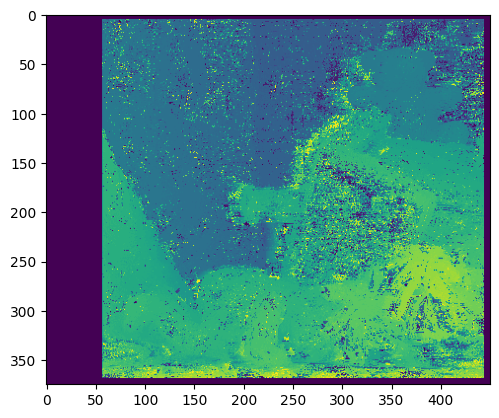

In [140]:
# Census transform
def census(im2, im6, d_max, M):
    H, W = im2.shape

    dis_map = np.zeros((H,W))

    #M = 31
    M_half = M//2

    # ignore the edge part of the image
    delta = M_half + d_max 
    
    #for row in range(delta, delta+1):
    for row in range(M_half, H - M_half-1):
    
        for col in range(delta, W - M_half -1):
        
            wind2 = im2[row-M_half:row+M_half+2, col-M_half:col+M_half+2]
            wind2_bin = np.ravel((wind2 > im2[row,col])*1)
        
            cost = [0] * d_max
            for i in range(d_max):
            
                wind6 = im6[row-M_half:row+M_half+2, col-i-M_half:col-i+M_half+2]
                wind6_bin = np.ravel((wind6 > im6[row,col-i])*1)
            
                cost[i] = (wind2_bin ^ wind6_bin).sum()
    
            dis_map[row, col] = np.argmin(cost)
    
        dis_map = dis_map.astype(np.uint8)
    
    plt.imshow(dis_map)
    
    return dis_map

print('>>>>>>>>>>> M = 11 <<<<<<<<<<<<<<')
dis_map_11 = census(im2, im6, d_max, 11)

>>>>>>>>>>> M = 21 <<<<<<<<<<<<<<


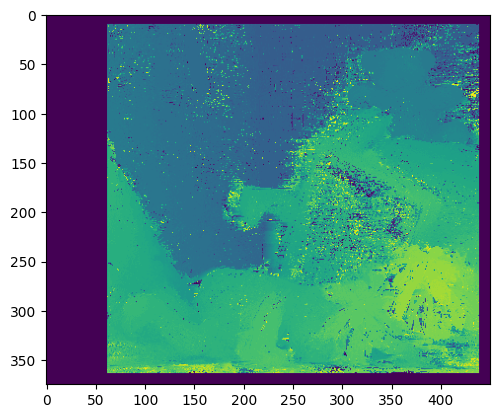

In [141]:
print('>>>>>>>>>>> M = 21 <<<<<<<<<<<<<<')
dis_map_21 = census(im2, im6, d_max, 21)

>>>>>>>>>>> M = 11 <<<<<<<<<<<<<<


C:\Users\Peng Ju\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


accuracy:  0.6953219060896014


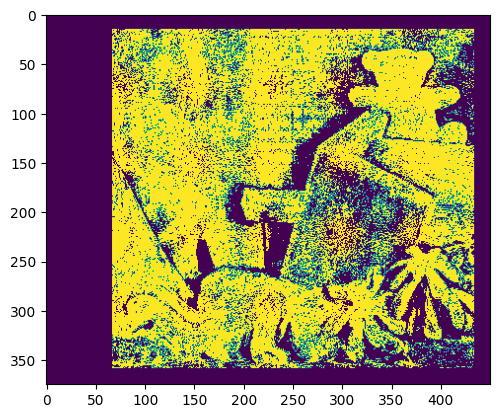

In [138]:
def accu_mask(dis_map, disp_true):

    H, W = dis_map.shape

    mask = np.zeros((H,W))
    
    M = 31
    M_half = M//2

    # ignore the edge part of the image
    delta = M_half + d_max 

    count_all = 0
    count_correct = 0

    for row in range(M_half, H - M_half-1):
        for col in range(delta, W - M_half -1):
            count_all += 1
            if abs(dis_map[row, col] - disp_true[row,col][0]) <= 2:
                count_correct += 1
                mask[row, col] = 255

    plt.imshow(mask)  
    accu = count_correct/count_all
    print('accuracy: ', accu)
    
    return count_correct/count_all, mask    

print('>>>>>>>>>>> M = 11 <<<<<<<<<<<<<<')
accu_11, map_11 = accu_mask(dis_map_11, disp2)

>>>>>>>>>>> M = 21 <<<<<<<<<<<<<<


C:\Users\Peng Ju\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


accuracy:  0.7571525885558583


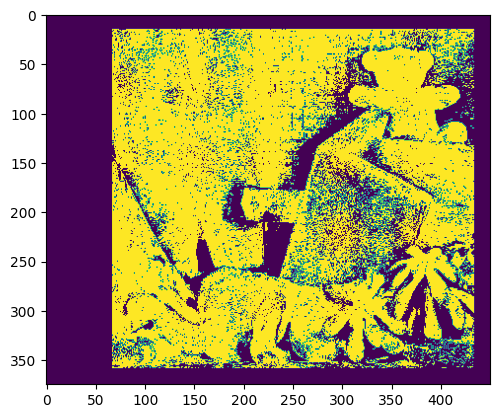

In [139]:
print('>>>>>>>>>>> M = 21 <<<<<<<<<<<<<<')
accu_21, map_21 = accu_mask(dis_map_21, disp2)